In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
!nvidia-smi

Fri May 13 01:32:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P0    27W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
import torch
torch.cuda.is_available()
#torch.cuda.device_count()

False

In [14]:
import matplotlib.pyplot as plt
from utils import figure_8
from utils import net

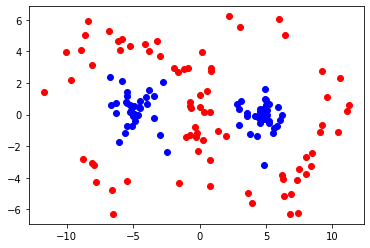

In [15]:
dataset = figure_8(150, var=2)
fig, ax = plt.subplots()
dataset.plot(ax)

In [16]:
net = net()

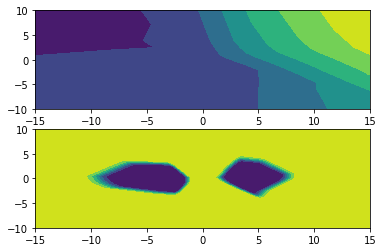

In [17]:
d = dataset.get_dataset()
fig, (ax1, ax2) = plt.subplots(2)
net.plot_decision_boundary(ax1)
net.train(d, 500)
net.plot_decision_boundary(ax2)

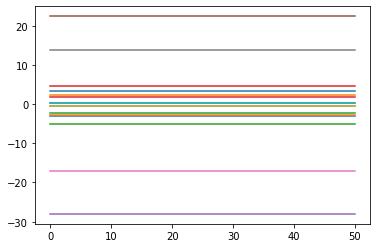

In [44]:
from positive_scaling_invariance import random_telep
from torch import nn
import numpy as np

criterion = nn.CrossEntropyLoss()
repeats = 50
a, b = 0.5, 1.5

data = d[:, 1:]
labels = d[:, :1]

outputs = np.empty(shape=(torch.numel(data[:, 0]),2, repeats+1))

outputs[:, :, 0] = net.forward(data).detach().numpy()

for repeat in range(repeats):
  # for each teleportation, record both outputs values of each datapoint
  random_telep(net, a, b)
  outputs[:, :, repeat+1] = net(data).detach().numpy()

x = np.linspace(0, repeats, repeats+1)

for i in [1, 2, 20, 35, 50, 75, 100, 150] :
  plt.plot(x, outputs[i,0, :])
  plt.plot(x, outputs[i,1, :])

3
1
2
3
